In [1]:
import pandas as pd
import numpy as np
from statsmodels import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


# Non-stationary & Stationary (Y_FE)
- 정상성 확보를 통해 안정성이 높아지고 예측력 향상
- Principle of  Parsimony에 따라 적은 모수만으로 모델링이 가능하기에 과적합 확률이 줄어듬
- 제곱, 루트, 로그, 차분 등

**Ex)**
![텍스트](https://otexts.com/fppkr/fpp_files/figure-html/stationary-1.png)  

- Trend: a/c/e/f/i | Seasonality: d/h/i | Cycle: g | Non-constant Variance: i

---
[Method]
1. Difference
        1. Trend
        2. Seasonal
2. Box
3. Log

In [2]:
## ADF 추세 제거 확인
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf
## KPSS 계정성 제거 확인
def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

## Difference
- Trend(추세): 시계열이 시간에 따라 증가, 감소 또는 일정 수준을 유지하는 경우
> - 확률과정의 결정론적 기댓값 함수를 알아내는 것  
> _1) 추세 추정($f(t)$) 후 추세 제거를 통한 정상성 확보_  
> _2) 차분 적용 후 추세 제거를 통한 정상성 확보_

<center>$(1-L^1)^d Y_t$</center>

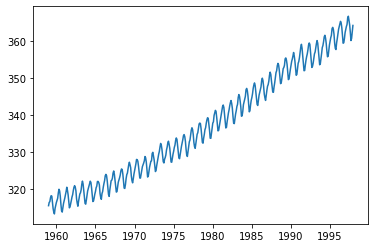

,Stationarity_adf
Test Statistics,2.321850
p-value,0.998969
Used Lag,13.000000
Used Observations,454.000000
Critical Value(1%),-3.444836
Maximum Information Criteria,269.654509


,Stationarity_kpss
Test Statistics,2.551066
p-value,0.010000
Used Lag,18.000000
Critical Value(10%),0.347000


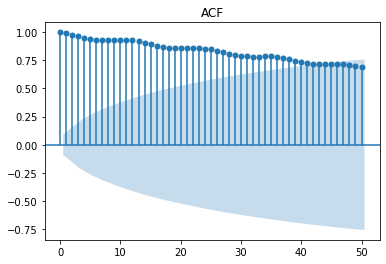

In [3]:
# Co2(Trend 제거)
raw = datasets.get_rdataset('co2', package='datasets').data
# Trend Dataset
plt.plot(raw.time, raw.value)
plt.show()
display(stationarity_adf_test(raw.value, []))
display(stationarity_kpss_test(raw.value, []))
sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True, title='ACF')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.075e+04
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:53:29   Log-Likelihood:                -1027.8
No. Observations:                 468   AIC:                             2062.
Df Residuals:                     465   BIC:                             2074.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      4.77e+04   3482.902     13.696      0.000    4.09e+04    5.45e+04
time           -49.1907      3.521    -13.971      0.000     -56.110     -42.272
I(time ** 2)     0.0128      0.001     14.342      0.000       0.011       0.015
==============================================================================
Omnibus:                       66.659   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.850
Skew:                          -0.116   Prob(JB):                     0.000133
Kurtosis:                       2.072   Cond. No.                     1.35e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

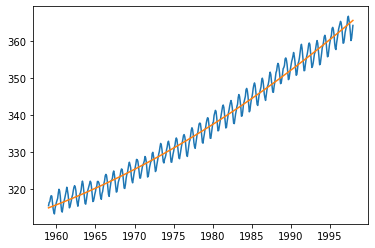

In [4]:
result = sm.OLS.from_formula(formula='value~time+I(time**2)', data=raw).fit() 
display(result.summary())

trend = result.params[0] + result.params[1] * raw.time + result.params[2] * raw.time**2
plt.plot(raw.time, raw.value, raw.time, trend)
plt.show()

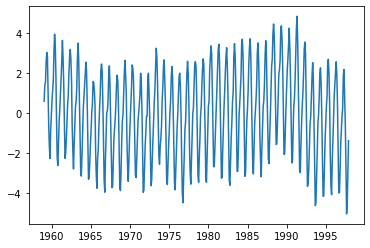

,Stationarity_adf
Test Statistics,-2.527950
p-value,0.108821
Used Lag,13.000000
Used Observations,454.000000
Critical Value(1%),-3.444836
Maximum Information Criteria,260.098601


,Stationarity_kpss
Test Statistics,0.171318
p-value,0.100000
Used Lag,18.000000
Critical Value(10%),0.347000


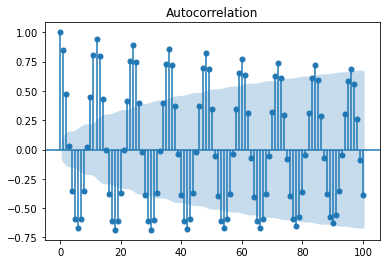

In [5]:
# Difference - Trend 제거 1
plt.plot(raw.time, result.resid) # Y_Target - Trend = resid
plt.show()
# ADF,KPSS Test
display(stationarity_adf_test(result.resid, []))
display(stationarity_kpss_test(result.resid, []))
# ACF graph Test
sm.graphics.tsa.plot_acf(result.resid, lags=100, use_vlines=True)
plt.show()

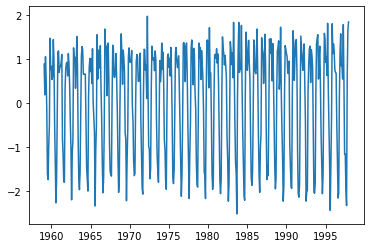

,Stationarity_adf
Test Statistics,-5.138087
p-value,0.000012
Used Lag,12.000000
Used Observations,454.000000
Critical Value(1%),-3.444836
Maximum Information Criteria,271.870851


,Stationarity_kpss
Test Statistics,0.040406
p-value,0.100000
Used Lag,18.000000
Critical Value(10%),0.347000


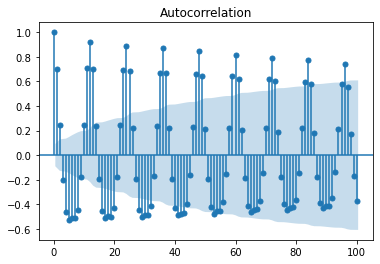

In [6]:
# Difference - Trend 제거 2
plt.plot(raw.time[1:], raw.value.diff(1).dropna())
plt.show()
# ADF, KPSS Test
display(stationarity_adf_test(raw.value.diff(1).dropna(), []))
display(stationarity_kpss_test(raw.value.diff(1).dropna(), []))
# ACF graph
sm.graphics.tsa.plot_acf(raw.value.diff(1).dropna(), lags=100, use_vlines=True)
plt.show()

## Difference
- Seasonality(계절성): 특정한 달/요일에 따라 기대값이 달리지는 것
> - 계절변수 더비화를 통해 추청 가능  
> _1) 계절성 추정($f(t)$) 후 계절성 제거를 통한 정상성 확보_  
> _2) 차분 적용 후 계절성 제거를 통한 정상성 확보_
<center>$(1-L^d) Y_t$</center>

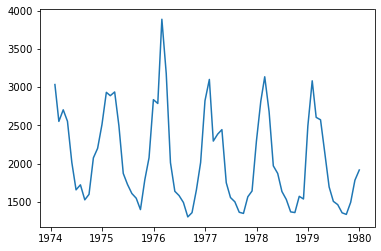

,Stationarity_adf
Test Statistics,-0.568650
p-value,0.877910
Used Lag,12.000000
Used Observations,59.000000
Critical Value(1%),-3.546395
Maximum Information Criteria,841.377559


,Stationarity_kpss
Test Statistics,0.651989
p-value,0.017910
Used Lag,12.000000
Critical Value(10%),0.347000


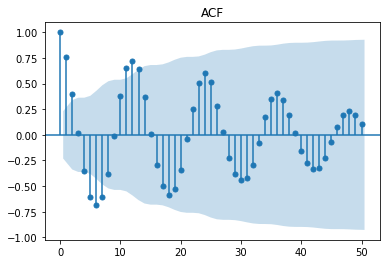

In [7]:
raw = datasets.get_rdataset('deaths', package='MASS').data
# Month setting
raw.time = pd.date_range('1974-01-01', periods=len(raw), freq='M')
raw['month'] = raw.time.dt.month
# Seasonal Dataset
plt.plot(raw.time, raw.value)
plt.show()
# Raw data test
display(stationarity_adf_test(raw.value, []))
display(stationarity_kpss_test(raw.value, []))
sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True, title='ACF')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     31.66
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           6.55e-21
Time:                        18:53:32   Log-Likelihood:                -494.38
No. Observations:                  72   AIC:                             1013.
Df Residuals:                      60   BIC:                             1040.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[1]   2959.3333    103.831     28.502      0.000    2751.641    3167.025
C(month)[2]   2894.6667    103.831     27.879      0.000    2686.975    3102.359
C(month)[3]   2743.0000    103.831     26.418      0.000    2535.308    2950.692
C(month)[4]   2269.6667    103.831     21.859      0.000    2061.975    2477.359
C(month)[5]   1805.1667    103.831     17.386      0.000    1597.475    2012.859
C(month)[6]   1608.6667    103.831     15.493      0.000    1400.975    1816.359
C(month)[7]   1550.8333    103.831     14.936      0.000    1343.141    1758.525
C(month)[8]   1408.3333    103.831     13.564      0.000    1200.641    1616.025
C(month)[9]   1397.3333    103.831     13.458      0.000    1189.641    1605.025
C(month)[10]  1690.0000    103.831     16.277      0.000    1482.308    1897.692
C(month)[11]  1874.0000    103.831     18.049      0.000    1666.308    2081.692
C(month)[12]  2478.5000    103.831     23.871      0.000    2270.808    2686.192
==============================================================================
Omnibus:                       19.630   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.630
Skew:                           0.787   Prob(JB):                     1.67e-11
Kurtosis:                       6.750   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

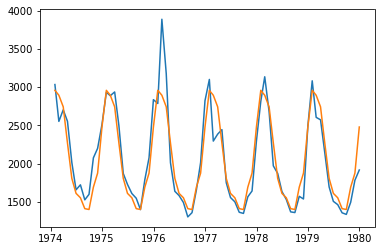

In [8]:
result = sm.OLS.from_formula(formula='value ~ C(month) - 1', data=raw).fit()
display(result.summary())

plt.plot(raw.time, raw.value, raw.time, result.fittedvalues)
plt.show()

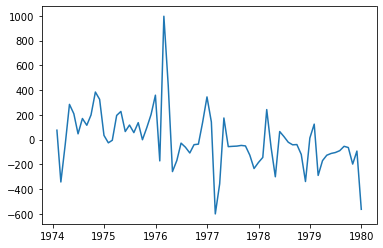

,Stationarity_adf
Test Statistics,-5.842931e+00
p-value,3.740637e-07
Used Lag,0.000000e+00
Used Observations,7.100000e+01
Critical Value(1%),-3.526005e+00
Maximum Information Criteria,8.123641e+02


,Stationarity_kpss
Test Statistics,0.538249
p-value,0.033052
Used Lag,12.000000
Critical Value(10%),0.347000


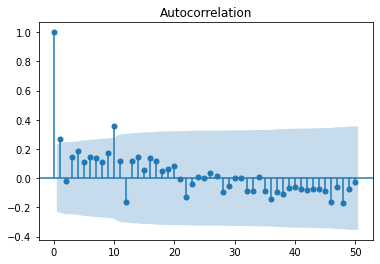

In [9]:
# Seasonal 제거 1
plt.plot(raw.time, result.resid) # resid
plt.show()
# ADF, KPSS Test
display(stationarity_adf_test(result.resid, []))
display(stationarity_kpss_test(result.resid, []))
# ACF graph
sm.graphics.tsa.plot_acf(result.resid, lags=50, use_vlines=True)
plt.show()

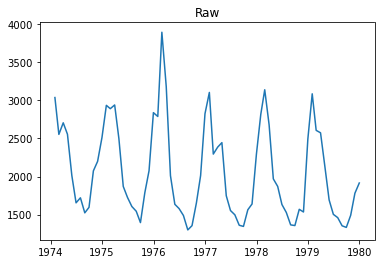

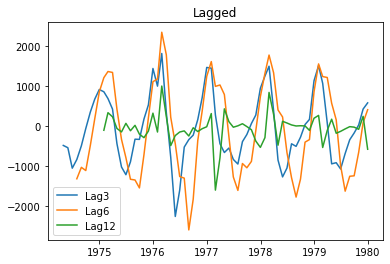

,Stationarity_adf
Test Statistics,-4.299976
p-value,0.000444
Used Lag,11.000000
Used Observations,54.000000
Critical Value(1%),-3.557709
Maximum Information Criteria,786.671043


,Stationarity_kpss
Test Statistics,0.349646
p-value,0.098859
Used Lag,11.000000
Critical Value(10%),0.347000


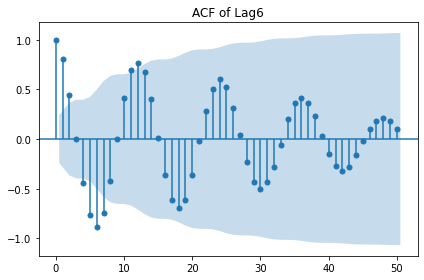

,Stationarity_adf
Test Statistics,-2.137208
p-value,0.229819
Used Lag,11.000000
Used Observations,48.000000
Critical Value(1%),-3.574589
Maximum Information Criteria,703.717969


,Stationarity_kpss
Test Statistics,0.09452
p-value,0.10000
Used Lag,11.00000
Critical Value(10%),0.34700


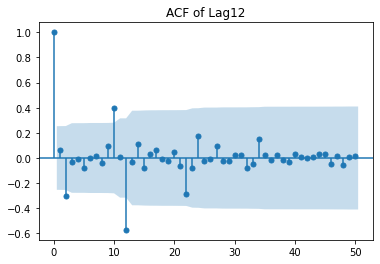

In [10]:
# Seasonal
# 계절성 제거 및 정상성 확인
## 방법2
# sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True)
# plt.show()

plt.plot(raw.time, raw.value)
plt.title('Raw')
plt.show()
seasonal_lag = 3
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 6
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 12
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
plt.title('Lagged')
plt.legend()
plt.show()

seasonal_lag = 6
display(stationarity_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationarity_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

seasonal_lag = 12
display(stationarity_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationarity_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.show()

## Box-Cox
- 정규분포가 아닌 자료를 정규분포로 변환하기 위해 사용
> - 모수(parameter) $\lambda$를 가지며, 보통 여러가지 $\lambda$ 값을 시도하여 가장 정규성을 높여주는 값을 사용






**Logarithm Transform**
- 시간흐름에 비례하여 값이 커지는 경우(분삭 증가)
- 비정상 확률 과정으로 표준 편차가 자료의 크기에 비례하여 증가하거나 지수 함수적으로 증가하는 경우
- 로그 변환한 확률 과정의 분산은 일정하기에 추세 제거로 기댓값이 0이 되면 정상 과정으로 모형화 가능

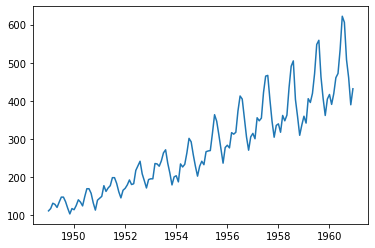

In [11]:
raw = sm.datasets.get_rdataset('AirPassengers').data
plt.plot(raw.time, raw.value)
plt.show()

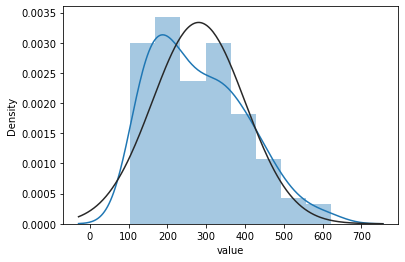

Lambda:  0.14802265137037945


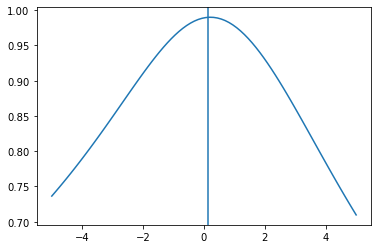

In [12]:
# raw 정규분포
sns.distplot(raw.value, norm_hist='True', fit=stats.norm)
plt.show()
# Box-Cox
x, y = stats.boxcox_normplot(raw.value, la=-5, lb=5)
y_transfer, l_opt = stats.boxcox(raw.value)
print('Lambda: ', l_opt)
plt.plot(x, y)
plt.axvline(x=l_opt)
plt.show()

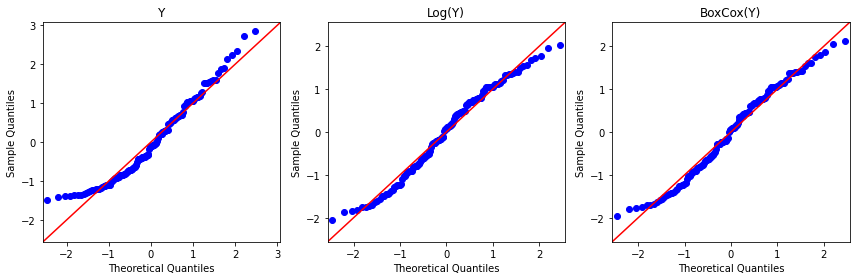

In [13]:
plt.figure(figsize=(12,4))
sm.qqplot(raw.value, fit=True, line='45', ax=plt.subplot(131))
plt.title('Y')
sm.qqplot(np.log(raw.value), fit=True, line='45', ax=plt.subplot(132))
plt.title('Log(Y)')
sm.qqplot(y_transfer, fit=True, line='45', ax=plt.subplot(133))
plt.title('BoxCox(Y)')
plt.tight_layout()
plt.show()

### Diff, Log 정상성 변환 Case


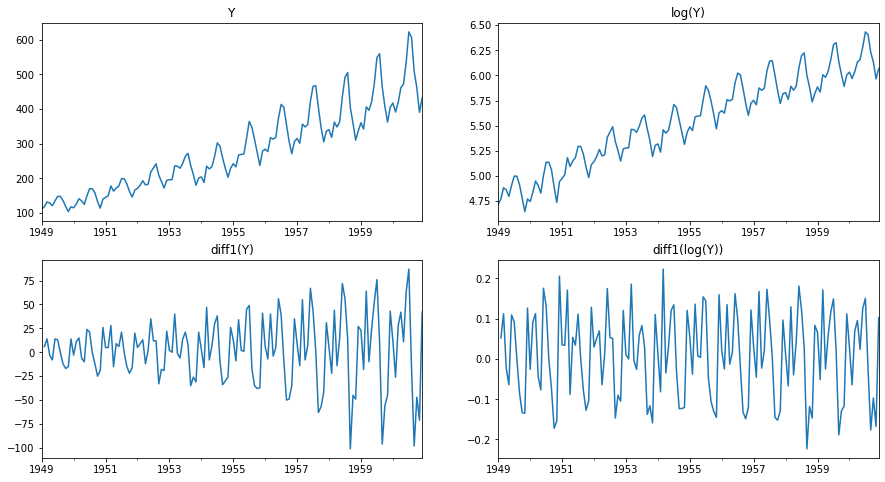

In [14]:
raw = sm.datasets.get_rdataset("AirPassengers").data
# time setting
raw.index = pd.date_range(start='1/1/1949', periods=len(raw['time']), freq='M')
del raw['time']

plt.figure(figsize=(15,8))
raw.plot(ax=plt.subplot(221), title='Y', legend=False)
np.log(raw).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
raw.diff(1).plot(ax=plt.subplot(223), title='diff1(Y)', legend=False)
np.log(raw).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()


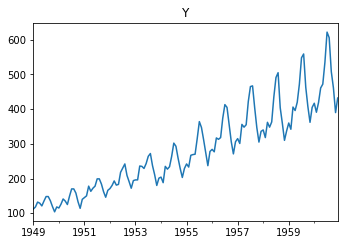

,Stationarity_adf
Test Statistics,0.815369
p-value,0.991880
Used Lag,13.000000
Used Observations,130.000000
Critical Value(1%),-3.481682
Maximum Information Criteria,996.692931


,Stationarity_kpss
Test Statistics,1.052175
p-value,0.010000
Used Lag,14.000000
Critical Value(10%),0.347000


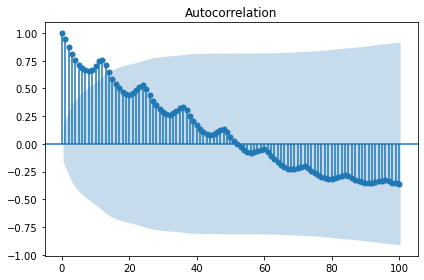

In [15]:
# Raw 'Y'
plt.figure(figsize=(12,8))
raw.plot(ax=plt.subplot(222), title='Y', legend=False)
plt.show()

display(stationarity_adf_test(raw.value, []))
display(stationarity_kpss_test(raw.value, []))
sm.graphics.tsa.plot_acf(raw.value, lags=100, use_vlines=True)
plt.tight_layout()
plt.show()

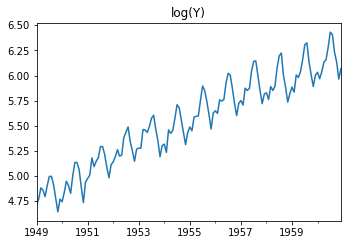

,Stationarity_adf
Test Statistics,-1.717017
p-value,0.422367
Used Lag,13.000000
Used Observations,130.000000
Critical Value(1%),-3.481682
Maximum Information Criteria,-445.399031


,Stationarity_kpss
Test Statistics,1.053981
p-value,0.010000
Used Lag,14.000000
Critical Value(10%),0.347000


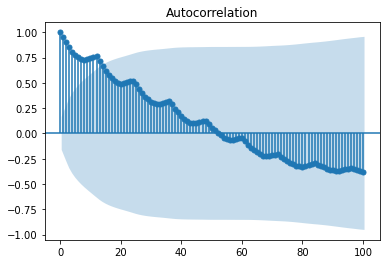

In [16]:
# log(Y)
plt.figure(figsize=(12,8))
np.log(raw).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
plt.show()

display(stationarity_adf_test(np.log(raw.value), []))
display(stationarity_kpss_test(np.log(raw.value), []))
sm.graphics.tsa.plot_acf(np.log(raw), lags=100, use_vlines=True)
plt.show()

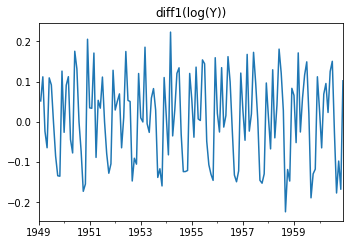

,Stationarity_adf
Test Statistics,-2.717131
p-value,0.071121
Used Lag,14.000000
Used Observations,128.000000
Critical Value(1%),-3.482501
Maximum Information Criteria,-440.358470


,Stationarity_kpss
Test Statistics,0.101545
p-value,0.100000
Used Lag,14.000000
Critical Value(10%),0.347000


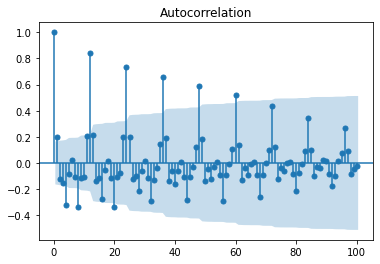

In [17]:
# diff1(Log(Y))
plt.figure(figsize=(12,8))
np.log(raw).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()

display(stationarity_adf_test(np.log(raw).diff(1).dropna(), []))
display(stationarity_kpss_test(np.log(raw).diff(1).dropna(), []))
sm.graphics.tsa.plot_acf(np.log(raw).diff(1).dropna(), lags=100, use_vlines=True)
plt.show()

In [18]:
seasonal_dist = sm.tsa.acf(np.log(raw).diff(1).dropna())[1:].argmax() + 1
seasonal_dist

12

,Stationarity_adf
Test Statistics,-4.443325
p-value,0.000249
Used Lag,12.000000
Used Observations,118.000000
Critical Value(1%),-3.487022
Maximum Information Criteria,-415.559753


,Stationarity_kpss
Test Statistics,0.108825
p-value,0.100000
Used Lag,13.000000
Critical Value(10%),0.347000


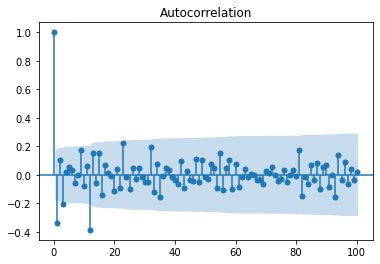

In [19]:
# Seasonal opt
display(stationarity_adf_test(np.log(raw).diff(1).diff(seasonal_dist).dropna(), []))
display(stationarity_kpss_test(np.log(raw).diff(1).diff(seasonal_dist).dropna(), []))
sm.graphics.tsa.plot_acf(np.log(raw).diff(1).diff(seasonal_dist).dropna(), lags=100, use_vlines=True)
plt.show()